# Sushi Tuesday Investment Group Inc.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize


def expected_portfolio_performance(weights, mean_returns, cov_matrix):
    p_return = np.dot(mean_returns, weights) * 252  # Annualized Return
    p_volatility = np.sqrt(weights.T @ cov_matrix @ weights) * np.sqrt(252)  # Annualized Volatility
    return p_return, p_volatility

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    p_return, p_volatility = expected_portfolio_performance(weights, expected_returns, cov_matrix)
    return - (p_return - risk_free_rate)/(p_volatility)

def efficient_frontier(expected_returns, cov_matrix, target_returns):
    frontier = []
    for target in target_returns:
        constraints = [
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: expected_portfolio_performance(x, expected_returns, cov_matrix)[0] - target}
        ]
        bounds = tuple((0, 1) for _ in range(len(expected_returns)))
        initial_weights = np.array([1 / len(expected_returns)] * len(expected_returns))

        result = minimize(lambda w: expected_portfolio_performance(w, expected_returns, cov_matrix)[1],
                          initial_weights, bounds=bounds, constraints=constraints)
        if result.success:
            frontier.append(result.fun)
        else:
            frontier.append(None)
    return [volatility for volatility in frontier if volatility is not None]  # Filter out None values


def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(len(mean_returns)))
    initial_weights = np.array([1 / len(mean_returns)] * len(mean_returns))

    result = minimize(negative_sharpe_ratio, initial_weights, args=(mean_returns, cov_matrix, risk_free_rate),
                      bounds=bounds, constraints=constraints)
    return result

def calculate_beta(asset_returns, market_returns):
    covariance = np.cov(asset_returns, market_returns)[0][1]
    print(covariance)
    market_variance = np.var(market_returns)
    beta = covariance / market_variance
    return beta

def find_best_portfolio(tickers, start_date, end_date):
    # Download stock data
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    new_tickers = data.columns.tolist()

    # Download market data
    market_data = yf.download("^GSPC", start=start_date, end=end_date)["Close"]

    # Get Daily returns
    daily_stock_returns = data.pct_change().dropna()
    cov_daily = daily_stock_returns.cov()

    market_returns = market_data.pct_change().dropna().iloc[:, 0]

    # Calculate betas
    betas = {}
    for ticker in new_tickers:
        betas[ticker] = calculate_beta(daily_stock_returns[ticker], market_returns)
    print(betas)

    # Apply CAPM model
    risk_free_rate = 0.04366 / 252 # Risk-free rate
    annualized_expected_market_return = market_returns.mean()
    print("Daily Expected Market Return:", annualized_expected_market_return)
    market_risk_premium = (annualized_expected_market_return - risk_free_rate)
    expected_returns = np.array([risk_free_rate + beta * (market_risk_premium) for beta in betas.values()])
    print("Expected Daily Returns:", expected_returns)

    # Efficient Frontier
    target_returns = np.linspace(expected_returns.min() * 252, expected_returns.max() * 252, 50)
    print(target_returns)
    frontier_volatilities = efficient_frontier(expected_returns, cov_daily, target_returns)

    # Max sharpe
    print("Calculating Sharpe")
    max_sharpe_portfolio = max_sharpe_ratio(expected_returns, cov_daily, risk_free_rate)
    max_sharpe_return, max_sharpe_volatility = expected_portfolio_performance(max_sharpe_portfolio.x, expected_returns, cov_daily)
    print("Max Sharpe Return:", max_sharpe_return)
    df = pd.DataFrame(max_sharpe_portfolio.x, index=new_tickers, columns=["Value"])
    pd.set_option('display.float_format', '{:.6f}'.format)

    plt.figure(figsize=(10, 6))
    plt.scatter(max_sharpe_volatility, max_sharpe_return, color='blue', s=200, label='Max Sharpe Ratio Portfolio')
    sharpe = (max_sharpe_return - risk_free_rate) / max_sharpe_volatility
    print(np.shape(frontier_volatilities))
    x = np.linspace(0, frontier_volatilities[-1], 100)
    x = np.linspace(0, frontier_volatilities[-1], 100)
    y = x * sharpe + risk_free_rate
    plt.plot(x, y)
    plt.plot(frontier_volatilities, target_returns, color='black', label='Efficient Frontier')
    return max_sharpe_return, max_sharpe_volatility, df

[*********************100%***********************]  3 of 3 completed
[*********************100%***********************]  1 of 1 completed


7.0676665480502e-05
6.0513843003329674e-05
0.00012430565763329245
{'AXP': np.float64(1.0937541883473871), 'NLR': np.float64(0.9364797955295096), 'SOXX': np.float64(1.9236877227774425)}
Daily Expected Market Return: 0.0009615272840531046
Expected Daily Returns: [0.00103543 0.00091146 0.00168965]
[0.22968691 0.23368903 0.23769115 0.24169327 0.24569539 0.2496975
 0.25369962 0.25770174 0.26170386 0.26570598 0.2697081  0.27371021
 0.27771233 0.28171445 0.28571657 0.28971869 0.29372081 0.29772292
 0.30172504 0.30572716 0.30972928 0.3137314  0.31773351 0.32173563
 0.32573775 0.32973987 0.33374199 0.33774411 0.34174622 0.34574834
 0.34975046 0.35375258 0.3577547  0.36175682 0.36575893 0.36976105
 0.37376317 0.37776529 0.38176741 0.38576953 0.38977164 0.39377376
 0.39777588 0.401778   0.40578012 0.40978224 0.41378435 0.41778647
 0.42178859 0.42579071]
Calculating Sharpe
Max Sharpe Return: 0.32623707053764506
(50,)
Max sharpe return: 0.32623707053764506
        Value
AXP  0.330305
NLR  0.229975


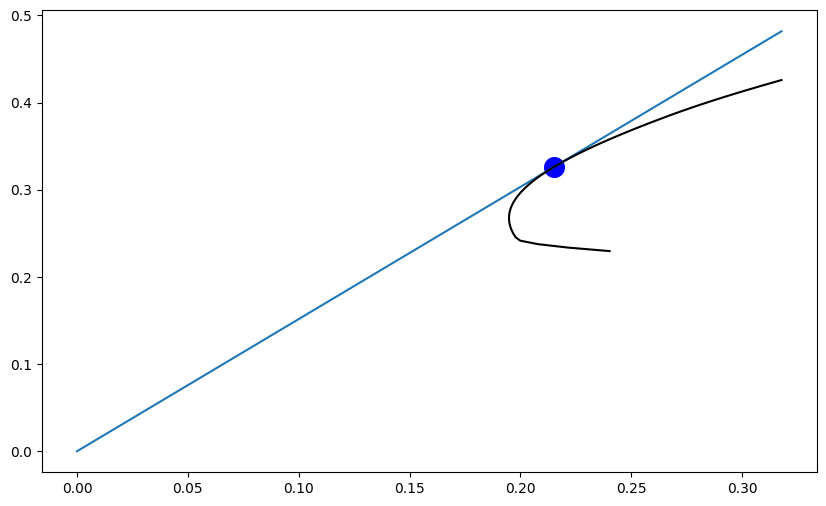

In [5]:
tickers = ["AXP", "NLR", "SOXX"]
start_date = "2022-12-18"
end_date = "2024-12-17"
max_sharpe_return, max_sharpe_volatility, df = find_best_portfolio(tickers, start_date=start_date, end_date=end_date)
print("Max sharpe return:", max_sharpe_return)
print(df)


In [32]:
# data = yf.download(tickers, start=start_date, end=end_date)
# info = yf.Ticker(tickers[0]).get_info()['industryKey']
# info = yf.Ticker(tickers[0]).get_info()['sectorKey']

# print(info)


[*********************100%***********************]  5 of 5 completed


technology


In [39]:
# Step 1: Fetch the list of S&P 500 companies (from Wikipedia)
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
snp500_table = pd.read_html(url)
snp500_df = snp500_table[0]  # The first table contains the data
# Extract the ticker symbols
tickers = snp500_df['Symbol'].tolist()
print(tickers)

# Step 2: Fetch data for all tickers using yfinance
data = {}
for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        info = stock.get_info()
        data[ticker] = {
            'Name': info.get('shortName', ''),
            'industryKey': info.get('industryKey', ''),
            'sectorKey': info.get('sectorKey', ''),
            'description': info.get('longBusinessSummary', '')
        }
    except Exception as e:
        print(f"Could not fetch data for {ticker}: {e}")

snp500_data = pd.DataFrame.from_dict(data, orient='index')
snp500_data.to_csv('snp500_data.csv', index=True)
print(snp500_data)


['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMTM', 'AEE', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ADM', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'ADP', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BALL', 'BAC', 'BAX', 'BDX', 'BRK.B', 'BBY', 'TECH', 'BIIB', 'BLK', 'BX', 'BK', 'BA', 'BKNG', 'BWA', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BLDR', 'BG', 'BXP', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT', 'CAT', 'CBOE', 'CBRE', 'CDW', 'CE', 'COR', 'CNC', 'CNP', 'CF', 'CRL', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CB', 'CHD', 'CI', 'CINF', 'CTAS', 'CSCO', 'C', 'CFG', 'CLX', 'CME', 'CMS', 'KO', 'CTSH', 'CL', 'CMCSA', 'CAG', 'COP', 'ED', 'STZ', 'CEG', 'COO', 'CPRT', 'GLW', 'CPAY', 'CTVA', 'CSGP', 'COST', 'CTRA', 'CRWD', 'CCI', 'CSX', 'CMI', 'CVS', 'DHR', '

In [46]:
print(snp500_data['sectorKey'].unique())


['industrials' 'healthcare' 'technology' 'utilities' 'financial-services'
 'basic-materials' 'consumer-cyclical' 'real-estate'
 'communication-services' 'consumer-defensive' 'energy' '']


In [45]:
start_date = "2023-01-01"
end_date = "2024-06-01"
for sector in snp500_data['sectorKey'].unique():
    tickers = snp500_data[snp500_data['sectorKey'] == sector]['sectorKey'].index.tolist()
    max_sharpe_return, max_sharpe_volatility, df = find_best_portfolio(tickers, start_date=start_date, end_date=end_date)
    print(f"Sector: {sector}")
    df_filtered = df[df['Value'] >= 0.04]
    print(df_filtered)
    df_filtered.to_csv('./weights/' + sector + ".csv")

[*********************100%***********************]  70 of 70 completed

1 Failed download:
['AMTM']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-06-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1717214400")')
[***                    6%                       ]  4 of 63 completed

Calculating Sharpe 
Sector: industrials
       Value
GE  0.100124
HWM 0.049398
MMM 0.073083
RTX 0.278899
TDG 0.074468
TT  0.048186
WAB 0.108433
WM  0.191310
XYL 0.057554


[*********************100%***********************]  63 of 63 completed


Calculating Sharpe 
Sector: healthcare
        Value
AMGN 0.083917
BSX  0.263050
DVA  0.071037
ELV  0.060917
LLY  0.209212
MCK  0.153430
MRNA 0.126420


[*********************100%***********************]  82 of 82 completed


Calculating Sharpe 
Sector: technology
        Value
BR   0.060276
DELL 0.093944
GDDY 0.124279
GRMN 0.154746
LDOS 0.168058
NVDA 0.222558
UBER 0.074735


[*********************100%***********************]  32 of 32 completed
[                       0%                       ]

Calculating Sharpe 
Sector: utilities
       Value
NEE 0.862878
VST 0.100117


[*********************100%***********************]  66 of 66 completed
[                       0%                       ]

Calculating Sharpe 
Sector: financial-services
        Value
ACGL 0.077390
BRO  0.094266
CBOE 0.223982
ERIE 0.055975
KKR  0.300154
PGR  0.184266


[*********************100%***********************]  22 of 22 completed
[***                    7%                       ]  4 of 55 completed

Calculating Sharpe 
Sector: basic-materials
       Value
ECL 0.473498
FCX 0.043235
LIN 0.112306
MLM 0.344651


[*********************100%***********************]  55 of 55 completed

1 Failed download:
['SW']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-06-01) (Yahoo error = "Data doesn\'t exist for startDate = 1672549200, endDate = 1717214400")')
[                       0%                       ]

Calculating Sharpe 
Sector: consumer-cyclical
        Value
CMG  0.350283
DECK 0.189368
PHM  0.203263
RCL  0.239208


[*********************100%***********************]  31 of 31 completed


Calculating Sharpe 
Sector: real-estate
        Value
IRM  0.558850
WELL 0.441150


[*********************100%***********************]  22 of 22 completed
[                       0%                       ]

Calculating Sharpe 
Sector: communication-services
        Value
GOOG 0.040423
META 0.358252
NFLX 0.179229
TMUS 0.344486


[*********************100%***********************]  36 of 36 completed
[*******               14%                       ]  3 of 22 completed

Calculating Sharpe 
Sector: consumer-defensive
        Value
BG   0.133142
COST 0.761285
WMT  0.105574


[*********************100%***********************]  22 of 22 completed


Calculating Sharpe 
Sector: energy
        Value
MPC  0.200483
TRGP 0.799517


[*********************100%***********************]  2 of 2 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (1d 2023-01-01 -> 2024-06-01)')
['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


Calculating Sharpe 


ZeroDivisionError: division by zero

In [ ]:
df.to_excel("snp500.xlsx")